# Challenges using gradient boosters

*I only recommend to look into this notebook if you are truly interested in machine learning. In case you are more interested in the soccer part, you do not need to go through it. None of the things we learn in this notebook will be needed in any of the following tutorials.*

Welcome back to another tutorial on soccer analytics! In this notebook we want to learn about some challenges that can arise when dealing with gradient boosting algorithms like [lightGBM](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) or [XGBoost](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/). Often times, these two algorithms are kind of seen as the holy grail when solving supervised machine-learning tasks on structured data. And rightfully though, as they often outperform other machine-learning approaches on these kind of tasks. While I'm also a big fan of these algorithms, they do come with some drawbacks that one should at least be aware of, before blindly using these algorithms in a real-life situation. Looking at what those drawbacks are and how to overcome some of those challenges, is the aim of this notebook.

We are going to start the notebook with a performance comparison of logistic regression and lightGBM, before we dive into some challenges that we find when using gradient (tree) boosters. The notebook is therefore split into the following chapters:

0. [Performance comparison](#performance) <br>We compare the performance of logistic regression and lightGBM on a simple expected goal model


1. [Challenge: Overfitting](#overfitting) <br>We look into overfitting and why it not only harms you model error, but might also affect the feature interpretation. Moreover, we learn about ways to eliminate overfitting


2. [Challenge: Feature interpretation](#feature_interpretation) <br>We get to know a great package called *shap* that allows us to do feature interpretation, even though gradient boosters are considered black-box models 


3. [Challenge: Missing monotonicity](#monotonicity) <br>We observe that gradient boosters are generally non-monotone, which might have a negative effect on the model credibility when presenting results to a non data scientist. We then learn how to overcome this problem by adding monotone constraints, but need to admit that enforcing "smoothness" to the predictions is an almost impossible task


4. [Challenge: No extrapolation](#extrapolation) <br>We look into the fact that gradient (tree) boosters are incapable of extrapolation and elaborate on what that means in the context of an expected goal model. We then learn about ways on how to conceal this problem 

While this might look like a tutorial on why <b>not</b> to use gradient boosters, by no means it is. As we already said in the previous notebook, everything always depends on what exactly you want to do with your model and which tasks you want to use it. There are many great use cases out there gradient boosters are ideal for and I've used them in many different projects. Nevertheless, instead of blindly using those algorithms, it is useful to know their limitations, especially in the context of presentability of model results. And to show you these limitations and how to overcome some of them, is exactly the idea of this notebook. 

Notice that we build a dummy model that serves as a helper to identify and work through the challenges that come with gradient boosters. However, this notebook <b>does not intend to build a good expected goal model using lightGBM nor is it seen as an introduction to lightGBM</b>, i.e. 
- no outlier detection at the beginning of the notebook
- no dedicated feature engineering nor error analysis
- no extensive hyperparameter optimization
- no introduction to lightGBM or XGBoost as there are a lot of great tutorials and notebooks out there (e.g. [here](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) and [here](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/))

If you want to build a state-of-the-art goal model using lightGBM or XGBoost, recommend you to go through both the previous notebook as well as this notebook and try to plug things together. However, do not solely rely on this notebook!

Notice furthermore, that we are going to touch more advanced topics in this notebook such as lightGBM and XGBoost itself, SHAP values, Baysian hyperparameter optimization or outlier detection using isolation forests. Describing these concepts in detail would not only bust the size of the notebook, but is also not the idea behind the soccer analytics project. I therefore often times only paste a link to another website where you can learn more about these concepts. I guess this makes way more sense than me trying to explain them here.

Ok, enough talking for now, let's get started! :-)

<b>Update</b>: In case you want to get a deeper understanding on how to use Random Forests for expected goal models, check out [this](https://github.com/andrewsimplebet/expected_goals_deep_dive) great series by Andrew Puopolo.

In [38]:
# import packages
import os
import pandas as pd
import numpy as np
import shap

import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
import plotly.graph_objects as go
import plotly.express as px

if os.getcwd().split(os.sep)[-1] == "notebooks":
    os.chdir("../")

import helper.io as io
import helper.expected_goal_model as goal_model

# this is very useful as it makes sure that always all columns and rows of a data frame are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Read the event data of all the leagues and extract only the shots

In [39]:
league = "all"
df_events = io.read_event_data(league, notebook="expected_goal_model")
df_shots = df_events[df_events["eventName"] == "Shot"].copy()

<a id="performance"></a>

# Performance comparison of logistic regression and lightGBM

Let's start our analysis by comparing the model performance of a logistic regression with the performance of an out-of-the-box lightGBM algorithm. 

In order to do so, we will use similiar features like the ones we used in the previous notebook. In order to not be too biased towards the logistic regression, we will, however, disregard the features that were specifically and under lots of work built to fix the flaws of the logistic regression. I'm hereby talking about the following features:
- *inFrontOfGoal* measuring whether a player was directly in front of the goal
- *angle* measuring the angle between the player and the goal
- *headerDistToGoalLine* measuring the distance to the goal line specifically for headers

But before we choose the features, let's first split the data into train and test set

In [40]:
df_train, df_test, _, _ = train_test_split(df_shots, df_shots["goal"], test_size=0.25, random_state=42)

Compute the features the same way as in the previous notebook

In [41]:
egm = goal_model.ExpectedGoalModelLogistic()

# create the same features as used in logistic regression
df_train = egm.create_features(df_train)
df_test = egm.create_features(df_test)

As mentioned above, let's only keep the completely natural features and not the ones that were especially designed for the logistic regression

In [42]:
features = ["distToGoalLine", "distToCenter", "counterAttack", "corner", "smartPass", "duel", "shotBefore", 
            "head/body", "weakFoot", "strongFoot"]

#### Training of the logistic regression

In [43]:
# training of the logistic regression on the train set

model_lr = LogisticRegression(random_state=42)
model_lr.fit(df_train[features], np.array(df_train["goal"]).ravel())

# prediction on the test set
pred_probs = model_lr.predict_proba(df_test[features])[:,1]

print("#################\n# Logistic reg. #\n#################")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['goal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['goal'], pred_probs)*100:.2f}%")


#################
# Logistic reg. #
#################
Log loss on test set: 0.28549
AUC on test set: 78.36%


Ok, log loss of 0.28549. As expected, this is fundamentally worse than what we had in the previous notebook. However, this also makes sense given that we did not consider 3 important features that we built manually to improve the logistic regression prediction. Let's see what lightGBM can do...

#### Training of the out-of-the-box lightGBM model

We build an out-of-the-box LGBM classifier below. In case you have not heard about lightGBM yet, I recommend you to go through this [explanation](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc). By the way, even though we use lightGBM in this notebook, all the insights and challenges are identical when using XGBoost.

In [44]:
# train an out-of-the-box lightGBM classifier
model = lgb.LGBMClassifier(random_state=42, objective="binary")
model.fit(df_train[features], df_train["goal"])

# predict the probabilities
pred_probs = model.predict_proba(df_test[features])[:,1]

print("############\n# LightGBM #\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['goal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['goal'], pred_probs)*100:.2f}%")

############
# LightGBM #
############
Log loss on test set: 0.28351
AUC on test set: 78.29%


Hm, this is somehow underwhelming, isn't it? We use this very fancy model and the log loss is only slightly better than with logistic regression. And the AUC is even worse... 

Let's look deeper into why this is the case and how we can fix this in the next section.

<a id="overfitting"></a>

# Challenge 1: Overfitting

You noticed that above we only focused on the error on the test set? You might say now: "Yes, of course, because that's what we are interested in. Being good on data, that the algorithm has seen, does not tell me anything." I agree, ultimately what counts is the performance on the test set. However, by not looking at the error on the training set, we are not able to identify one very common issue, namely <b>overfitting</b>. 

In very easy words, overfitting describes the behavior, that a model learns the training data too well and can therefore not distinguish between noise and actual signal any more. If you haven't heard about overfitting yet, you can quickly read about it [here](https://elitedatascience.com/overfitting-in-machine-learning) or watch [this](https://www.youtube.com/watch?v=Anq4PgdASsc) short video. So, while overfitting is usually not a big problem with "simple" models such as logistic regression, it is *very* often a problem with more complex models such as gradient boosters, random forests or neural networks. Hm, ok, but that raises three questions that we are going to answer in the remainder of this section. 

1. Why is overfitting bad?
2. How can we detect overfitting?
3. What can we do against overfitting?

### Why is overfitting bad?

Overfitting is bad for two reasons:

- A model that overfits has often a worse performance on the test set than a non-overfitting model
- An overfitting model brings us into huge trouble when interpreting features importances

While the first point is hopefully obvious after you have read the link above or watched the video, the second might be a little bit more complex to understand. Let's therefore quickly come up with an example.

In [45]:
df = pd.DataFrame({"distToGoalLine": np.arange(9,10,0.1), 
                   "bodyPart": ["header","foot"] * 4 + ["foot","header"], 
                   "goal": [0,1] * 5})
df

,distToGoalLine,bodyPart,goal
0,9.0,header,0
1,9.1,foot,1
2,9.2,header,0
3,9.3,foot,1
4,9.4,header,0
5,9.5,foot,1
6,9.6,header,0
7,9.7,foot,1
8,9.8,foot,0
9,9.9,header,1


Ok, so what is the situation? We have 10 shots, 5 of which resulted in a goal and 5 did not. If we look at the body part, 4/5 shots with the foot went in and 1/5 headers went in. Regarding the distance to the goal line, shots from 9.1m, 9.3m, 9.5m, 9.7m and 9.9m went in, while the others did not. 

If I asked you, which feature contains any information and which feature doesn't, your answer would be very clear, wouldn't it? Clearly, it is very important whether you shoot with the head or the foot, while the distance does not make any difference (at least not in our toy example :-)). So what would a highly overfitted model do? It would learn that shots from exactly 9.10m go in, while shots from exactly 9.00m or 9.20m don't etc. So what would be the most important feature for an overfitted model? Correct, the distance to the goal line. This feature can explain to 100% whether the shot results in a goal or not. So, you see while overfitting is a problem for feature interpretation? ;-)

### How do we detect overfitting?

Gladly, this is pretty simple! :-) All we need to do is to compare the error between the training dataset and the test set. 

*If the error on the training data is significantly lower than on the test data, the model overfits.*

So, let's check whether our models overfit. (Actually, we should have tested for overfitting of the logistic regression already in the previous notebook, but I did not want to overload you with yet another machine learning terminology)

Let's start with the logistic regression

In [46]:
# training of the logistic regression on the train set
model_lr = LogisticRegression(random_state=42)
model_lr.fit(df_train[features], np.array(df_train["goal"]).ravel())

# prediction on training and test set
pred_probs = model_lr.predict_proba(df_test[features])[:,1]
pred_probs_train = model_lr.predict_proba(df_train[features])[:,1]

df_train["pred_lr"] = pred_probs_train
df_test["pred_lr"] = pred_probs

print("#################\n# Logistic reg. #\n#################")

print("\nTest set\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['goal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['goal'], pred_probs)*100:.2f}%")

print("\nTraining set\n############")
print(f"Log loss on train set: {sk_metrics.log_loss(df_train['goal'], pred_probs_train):.5f}")
print(f"AUC on train set: {sk_metrics.roc_auc_score(df_train['goal'], pred_probs_train)*100:.2f}%")

#################
# Logistic reg. #
#################

Test set
############
Log loss on test set: 0.28549
AUC on test set: 78.36%

Training set
############
Log loss on train set: 0.28771
AUC on train set: 77.52%


Nice, this looks very good, as the test set error is even slightly smaller than the training data set error. So, there is definitely no overfitting in place! :-)

Let's see how the situation looks like for lightGBM

In [47]:
pred_probs = model.predict_proba(df_test[features])[:,1]
pred_probs_train = model.predict_proba(df_train[features])[:,1]

df_train["prediction"] = pred_probs_train
df_test["prediction"] = pred_probs

print("############\n# LightGBM #\n############")

print("\nTest set\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['goal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['goal'], pred_probs)*100:.2f}%")

print("\nTraining set\n############")
print(f"Log loss on train set: {sk_metrics.log_loss(df_train['goal'], pred_probs_train):.5f}")
print(f"AUC on train set: {sk_metrics.roc_auc_score(df_train['goal'], pred_probs_train)*100:.2f}%")

############
# LightGBM #
############

Test set
############
Log loss on test set: 0.28351
AUC on test set: 78.29%

Training set
############
Log loss on train set: 0.26363
AUC on train set: 82.62%


Hm, not that good any more, is it? While we have a log loss of 0.28351 on the test set, it is at 0.26363 on the training set. This is not a huge overfitting and you will definitely see much worse on some of your future projects, but it is still something we should try to fix. But how do we fix overfitting? 

### What can we do against overfitting?

When having to deal with overfitting, there are generally speaking 3 strategies to deal with it:

1. Increase the number of data points
2. Reduce the number of features
3. Adapt / simplify the model

Unfortunately, increasing the number of data points is no option here as the data is what it is. So the first strategy does not work for us. Given that we only have a very small number of features at the moment, also strategy number two does not seem to be adequate here. So it seems like we are stuck with the third strategy. But, how the hell do we simplify our lightGBM model?

Unlike the logistic regression, which we could not tweak a lot, more complex models come with a long list of hyperparameters (see [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for all hyperparameters for lightGBM). A set of hyperparameters is basically a configuration of our model. And there are some configurations that are "simpler" and some are more "complex". Now, finding the right balance between "simple" and "complex" is the task of a so-called hyperparameter optimization. I will not go into detail regarding hyperparameter optimization as it is a huge topic itself and there are quite a lot of good resources already out there (e.g. [here](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models) for a starter into hyperparameter optimization, [here](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search) for code on grid search and random seach or [here](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a) for a more advanced Baysian approach).

Let me add one sentence to overfitting in logistic regression. If this happens to you, you most probably have too many features that go into your model. From my experience, the most common reason for why this happens is, that categorical features with many different values are being converted into dummy variables which let's the number of features explode. So, when you find your logistic regression to be overfitting, I would start by looking into this. ;-)

Ok, so here is the set of hyperparameters that I found using the Baysian approach. Notice that I will not go into detail on how I found them as this would definitely blow up the size of this notebook. But if interested, you can check out the links above to see how you can implement it yourself. Having said this, I did also not bother to try to optimize things a lot, but took the first solid hyperparameter combination ;-) 

In [48]:
hyp = {'boosting_type': 'gbdt', 
       'colsample_bytree': 0.9053563761947043, 
       'is_unbalance': False, 
       'learning_rate': 0.03811321514778682, 
       'min_child_samples': 395, 
       'n_estimators': 118, 
       'num_leaves': 20, 
       'reg_alpha': 0.5617832258471822, 
       'reg_lambda': 0.34491347534610917, 
       'subsample_for_bin': 140000, 
       'subsample': 0.5869782389570299, 
       'objective': 'binary'}

Let's see if the overfitting was reduced

In [49]:
model = lgb.LGBMClassifier(**hyp)
model.fit(df_train[features], df_train["goal"])

pred_probs = model.predict_proba(df_test[features])[:,1]
pred_probs_train = model.predict_proba(df_train[features])[:,1]

df_train["prediction"] = pred_probs_train
df_test["prediction"] = pred_probs

print("############\n# LightGBM #\n############")

print("\nTest set\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['goal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['goal'], pred_probs)*100:.2f}%")

print("\nTraining set\n############")
print(f"Log loss on train set: {sk_metrics.log_loss(df_train['goal'], pred_probs_train):.5f}")
print(f"AUC on train set: {sk_metrics.roc_auc_score(df_train['goal'], pred_probs_train)*100:.2f}%")

############
# LightGBM #
############

Test set
############
Log loss on test set: 0.28078
AUC on test set: 78.92%

Training set
############
Log loss on train set: 0.27695
AUC on train set: 79.58%


Great! :-) Exactly the way we wanted it, overfitting was clearly reduced with the log loss on the training set now being 0.27695 instead of 0.26323. And notice that the error on the test set was also reduced from 0.28351 to now 0.28078. 

Cool, we overcame the problem of overfitting and are now in a situation in which we outperform the logistic regression when using the same set of rudimentary features (log loss of 0.28078 vs 0.28549). From my experience this is almost always the case, especially when not building special features to overcome some of the flaws of a logistic regression (I'm speaking about features such as the *inFrontOfGoal* feature). 

### Summary

<b> In most real-world machine-learning tasks, a well-calibrated gradient booster such as lightGBM or XGBoost outperforms a logistic regression when using the same set of features </b>  

Ok, so the situation is clear, isn't it? We wasted our time in the previous notebook trying to understand logistic regression, while we should have used lightGBM in the first place. Let me tell you that I'm a big fan of lightGBM and have used it in various projects. Nevertheless, unfortunately the situation is not quite as clear as it seems to be from the above statement as
- often times smartly, hand-crafted features can bring a logistic regression to an (almost) similiar performance. This is especially true when dealing with rather simple problems with a relatively small number of features
- lightGBM comes with some (potential) challenges that might not hurt the log loss but do might hurt the model credibility when presenting results in real life

We have already learned about hand-crafted features for logistic regression in the previous notebook. So let's look into these challenges that might arise with lightGBM.

<a id="feature_interpretation"></a>

# Challenge 2: Difficult feature interpretation

Arguably, the most common argument *against* using lightGBM or XGBoost is, that it is a black-box model and features can therefore not be interpreted. Funny enough, out of all the challenges that we consider in this notebook, this is in my opinion the one that is the simplest to solve thanks to a great package called *shap*. The package will help us to solve two questions we also had in the previous notebook: 

1. Does a variable have a positive or negative impact on the likelihood to score?
2. What are the most important features?

Again, I'm going to focus solely on how we can answer those questions and do not talk much about what SHAP values are in detail. Nevertheless, I highly recommend you to read about them [here](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

### Does a variable have a positive or negative impact on the likelihood to score?

Let us first compute the SHAP values and draw the graph and then look into the interpretation.

c:\programs_clemens\anaconda3\envs\soccer_analytics\lib\site-packages\shap\explainers\tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.

c:\programs_clemens\anaconda3\envs\soccer_analytics\lib\site-packages\shap\explainers\tree.py:249: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



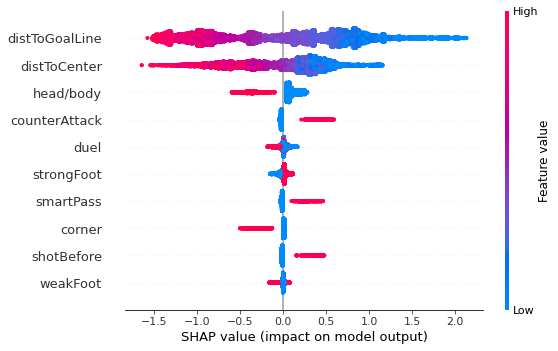

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train[features])

shap.summary_plot(shap_values[1], df_train[features], plot_type="dot")

That's a nice looking chart, isn't it? So how do we interpret it? In the end, if we just want to understand whether a feature has a positive or negative impact, the idea is pretty simple: For each feature you need to only focus whether the red and blue dots appear on the left side of the y-axis or the right side of the y-axis. If the red dots are on the right and the blue dots on the left, this means the higher the value of the feature the more likely to score. And vice versa, if the red dots are on the left and the blue dots on the right, the higher the value of the feature the less likely to score.

So, let's look at the *distToGoalLine* feature for example. Red dots are on the left and blue dots on the right. This means the bigger the distance to the goal line the less likely a player is to score. That makes perfect sense, doesn't it? Overall, if you go through the list, all of the features make a lot of sense, don't they? And also when comparing the feature influences according to the SHAP values to the influences in the last notebook, you will see that they are completely aligned :-)

So that was easy, wasn't it? 

Again, this is only thought of as an example to show you the existence of SHAP values and how to use them. I highly urge you to read more about them before using them in any real-world project!

### What are the most important features?

Fortunately, we can again use the SHAP values to answer this question. This can be done by looking at the mean absolute SHAP value for each feature, which can be observed in the chart below.

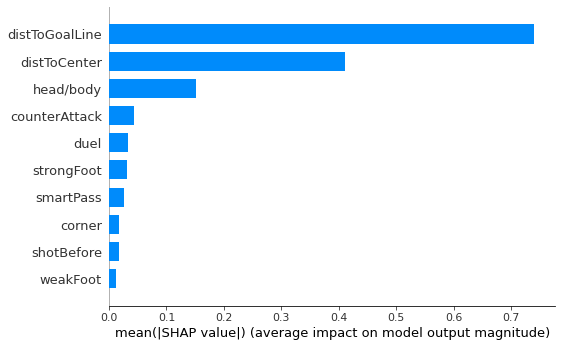

In [51]:
shap.summary_plot(shap_values[1], df_train[features], plot_type="bar")

Interpretation is now as easy as it could be. The longer the bar the more important the feature. And now, guess what the 4 most important features were in the logistic regression: Correct, *distToGoalLine*, *distToCenter*, *head/body* and *counterAttack* :-)

### Summary

While lightGBM is a black box model, it is still rather simple to identify which features are the most important ones and whether they affect the scoring probability positively or negatively. As said before, in my opinion a lack of feature interpretation should not be a reason not to use lightGBM. 

A whole different story, however, is the next challenge!

<a id="monotonicity"></a>

# Challenge 3: Missing monotonicity

You remember that for the logistic regression all features are montone in the target, given that all other features stay constant? Well, this is not the case for lightGBM. While the non-monotonicity is often useful as lightGBM can easily learn more complex representations, it is sometimes not what we would expect nor what we want to algorithm to do. 

Let's look at an example to make things a little bit clearer. More precisely, let's look at the scoring probabilities when shooting with the strong foot from a distance of 23m - 30m.

In [52]:
def create_sample_shots(dist_goal_line, dist_center, duel, corner, smart_pass, shot_before, counter_attack, body_part):
    """
    Helper function to create sample shots for different distance to the goal line and all other variables being fixed.
    """
    
    # build a data frame with all the shots
    df_shots = pd.DataFrame()
    df_shots["distToGoalLine"] = dist_goal_line 
    df_shots["distToCenter"] = dist_center
    df_shots["duel"] = duel
    df_shots["corner"] = corner
    df_shots["smartPass"] = smart_pass
    df_shots["shotBefore"] = shot_before
    df_shots["counterAttack"] = counter_attack

    # set up the body part
    for i, col in enumerate(["head/body", "weakFoot", "strongFoot"]):
        df_shots[col] = 1*(col == body_part)
    
    return df_shots

In [53]:
# Set assumptions about the shot
dist_goal_line = np.arange(23,31)
dist_center = 0
counter_attack = 0
duel = 0
corner = 0
smart_pass = 0
shot_before = 0
body_part = "strongFoot"

# create a sample data frame with the shots
df_sample = create_sample_shots(dist_goal_line, dist_center, counter_attack, duel, corner, smart_pass, 
                                shot_before, body_part)

# get the prediction from the model
df_sample["predLGBM"] = model.predict_proba(df_sample[features])[:,1] * 100

# plot the scoring probability
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBM"],
                         mode='lines',
                         name='LightGBM'))

fig.update_layout(title="Scoring probability",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

Hm, that looks very weird... While the scoring probability from 24 meters is ~2.97%, it is only ~2.55% from 25 meters and then goes up to ~2.64% for 26 meters. That doesn't make any sense, does it? I mean it is exactly the same shot and the model tells us that if you go back and take the shot from 26m instead of 25m, the scoring probability raises... So, can we fix this problem?

### Solution attempt

Some of you might know that you can add montone constraints to both lightGBM and XGBoost (unfortunately, this does not exist for a random forest). So this one is easy, isn't it? We can just add a constraint telling the model to be monotone in *distToGoalLine* and everything is good! So let's do exactly this:

In [54]:
# notice that -1 means monotone decreasing
monotone_features = [0 if feat != "distToGoalLine" else -1 for feat in features]

model_mon = lgb.LGBMClassifier(**hyp, monotone_constraints=monotone_features)
model_mon.fit(df_train[features], df_train["goal"])

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9053563761947043, importance_type='split',
               is_unbalance=False, learning_rate=0.03811321514778682,
               max_depth=-1, min_child_samples=395, min_child_weight=0.001,
               min_split_gain=0.0,
               monotone_constraints=[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               n_estimators=118, n_jobs=-1, num_leaves=20, objective='binary',
               random_state=None, reg_alpha=0.5617832258471822,
               reg_lambda=0.34491347534610917, silent=True,
               subsample=0.5869782389570299, subsample_for_bin=140000,
               subsample_freq=0)

And let's now check how our predictions look like

In [55]:
# get the prediction from the model
df_sample["predLGBM"] = model_mon.predict_proba(df_sample[features])[:,1] * 100

# plot the scoring probability
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBM"],
                         mode='lines',
                         name='LightGBM'))

fig.update_layout(title="Scoring probability",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

Nice, this looks way better! So, we solved the problem, didn't we? But wait, what about shots that are close to the goal line but not in front of the goal? They should get a relatively small scoring probability as the angle it pretty small. Does our model capture this?

In [56]:
#Set assumptions about the shot
dist_goal_line = np.arange(1, 15)
dist_center = 15
counter_attack = 0
duel = 0
corner = 0
smart_pass = 0
shot_before = 0
body_part = "strongFoot"

# create a sample data frame with the shots
df_sample = create_sample_shots(dist_goal_line, dist_center, counter_attack, duel, corner, smart_pass, 
                                shot_before, body_part)

# get the prediction from the model
df_sample["predLGBM"] = model.predict_proba(df_sample[features])[:,1] * 100
df_sample["predLGBMMonotone"] = model_mon.predict_proba(df_sample[features])[:,1] * 100

# plot the scoring probability
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBM"],
                         mode='lines',
                         name='Non-monotone model'))

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBMMonotone"],
                         mode='lines',
                         name='Monotone model'))

fig.update_layout(title="Scoring probability",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

Oh no, while the non-monotone model was pretty good in capturing the fact that even though the distance gets bigger the scoring probability gets bigger as the angle get wider, we destroyed this by implementing the monotone constraint. :-( 

Hm, let's think about whether there is any way to fix this... So what we said was, that given all other features stay the same, the monotone constraint makes sure that the further from the goal line, the less likely it is to score. So, what happens if we add the feature *angleClip* (to remind you: this measures the angle to the post, but was clipped to only keep the small angles)? This way we can make sure that when the angle stays the same, i.e. we are in front of the goal or the angle is very wide, the monotonicity constraint is active. For small angles, however, we do have the freedom to be non-monotone as this is what we want. And that way we can even say that we also want to be monotone decreasing in the distance to the center. So, let's try this out...

In [57]:
# notice that -1 means monotone decreasing
features_mon = features + ["angleClip"]
monotone_features = [0 if feat not in ["distToGoalLine", "distToCenter"] else -1 for feat in features_mon]

model_mon2 = lgb.LGBMClassifier(**hyp, monotone_constraints=monotone_features)
model_mon2.fit(df_train[features_mon], df_train["goal"])

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9053563761947043, importance_type='split',
               is_unbalance=False, learning_rate=0.03811321514778682,
               max_depth=-1, min_child_samples=395, min_child_weight=0.001,
               min_split_gain=0.0,
               monotone_constraints=[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               n_estimators=118, n_jobs=-1, num_leaves=20, objective='binary',
               random_state=None, reg_alpha=0.5617832258471822,
               reg_lambda=0.34491347534610917, silent=True,
               subsample=0.5869782389570299, subsample_for_bin=140000,
               subsample_freq=0)

In [58]:
# add the angle to the sample data
df_sample = egm.create_features(df_sample, overwrite=False)

df_sample["predLGBMMonotone"] = model_mon2.predict_proba(df_sample[features_mon])[:,1] * 100


# plot the scoring probability
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBM"],
                         mode='lines',
                         name='Non-monotone model'))

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBMMonotone"],
                         mode='lines',
                         name='Monotone model'))

fig.update_layout(title="Scoring probability",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

Ok, nice, we are now capable of capturing the non-monotonicity by adding the *angle* feature. However, to be completely honest with you, the bump at 11 meters compared to 10m and 12m does still look a little bit weird, doesn't it? I would bet that in reality this curve is smoother and the bump doesn't happen...

### Summary

While lightGBM comes with the possibility to enforce monotonicity in features, it can in reality be rather difficult to do so in a meaningful way. Having said this, enforcing "smoothness" for non-monotone features is often almost impossible. So:

<b>If it is highly relevant for your model to have monotone and "smooth" predictions and you would be willing to potentially trade this for some model accuracy, there are often better alternatives out there than lightGBM.</b>

<a id="extrapolation"></a>

# Challenge 4: No extrapolation

In this chapter we want to look into another potential drawback of lightGBM, namely the non-ability for extrapolation. 

But first, what is extrapolation? Extrapolation is the estimation of the value of a new data point which is outside the range of previously observed values.

### Toy example

Let me try to explain this to you with an toy *regression* example. I know that we have not yet looked into regression problems but I believe that the problems becomes way clearer with a regression rather than a classification example. And trust me, the underlying problem is the same as we will see below. 

Ok, so let's build our toy example in which the otucome raises monotone in a feature X. 

In [59]:
np.random.seed(42)
x = np.arange(1,98)
vals = x / 2 + np.random.normal(0,1,len(x))
df = pd.DataFrame({"x": np.arange(1,98), 
                   "value": vals})

Let's check how the data points look like

In [60]:
fig = px.scatter(df, x="x", y="value")
fig.show()

Ok, let's now do the following experiment. We use the data points 1 - 60 for training and the data points > 60 for testing. You see that this way values in our test are *outside* the range of values we are seeing in our training set, i.e. we are clearly in a situation of extrapolation. 

#### Linear regression

Let's check how good a linear regression is capable of predicting the values in the test set. And notice, that as mentioned above, as this is a regression rather than a classification problem, we use linear regression instead of logistic regression.

In [61]:
dummy_train = df[df["x"] <= 60].copy()
dummy_test = df[df["x"] > 60].copy()

lr = LinearRegression()
lr.fit(np.array(dummy_train["x"]).reshape(-1, 1), dummy_train["value"])

pred_vals = lr.predict(np.array(dummy_test["x"]).reshape(-1, 1))

In [62]:
df["set"] = np.where(df["x"] <= 60, "Train", "Test")
fig = px.scatter(df, x="x", y="value", color="set")
fig.add_trace(go.Scatter(x=dummy_test["x"], y=pred_vals,
                         mode='lines',
                         name='prediction'))

fig.update_layout(title="Linear Regression")

fig.show()

Nice, that looks very well, doesn't it? So, let's do the same thing for lightGBM...

#### LightGBM

In [63]:
lgbm = lgb.LGBMRegressor()

lgbm.fit(np.array(dummy_train["x"]).reshape(-1, 1), dummy_train["value"])

pred_vals = lgbm.predict(np.array(dummy_test["x"]).reshape(-1, 1))

fig = px.scatter(df, x="x", y="value", color="set")
fig.add_trace(go.Scatter(x=dummy_test["x"], y=pred_vals,
                         mode='lines',
                         name='prediction'))
fig.update_layout(title="LightGBM")

fig.show()

Whut?! What the hell is this? The prediction is completely off... That is what I meant above, a gradient booster is extremely bad in extrapolation. Or to put in other words:

<b> Gradient (tree) boosters will always predict values that are in the same range as observed on the training set. </b>

And as in the above example the training set only contains values ~ 0 - 30, it will *always* only predict values between 0 and 30.

### Long-range problem

Ok, good, so we look at this toy example for which lightGBM did not work. But why should we care in our real-world example? Let's look into the prediction we make when shooting the ball from a long-range. (Btw, notice that above we did not deal with outliers. I actually did that on purpose to show you this example ;-)) 

Let's start by creating same sample shots with the strong foot, but from long-range, i.e. shots between 30m and 100m from the goal.  

In [64]:
# Set some assumptions about the shot (other than the distance)
dist_goal_line = np.arange(28,101)
dist_center = 0
counter_attack = 0
duel = 0
corner = 0
smart_pass = 0
shot_before = 0
body_part = "strongFoot"

df_sample = create_sample_shots(dist_goal_line, dist_center, counter_attack, duel, corner, smart_pass, 
                                shot_before, body_part)
# add the angle to the sample data
df_sample = egm.create_features(df_sample, overwrite=False)

Let's predict the scoring probability with both the logistic regression and lightGBM

In [65]:
df_sample["predLR"] = model_lr.predict_proba(df_sample[features])[:,1] * 100
df_sample["predLGBM"] = model_mon2.predict_proba(df_sample[features_mon])[:,1] * 100

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLR"],
                         mode='lines',
                         name='Logistic Regression'))

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predLGBM"],
                         mode='lines',
                         name='LightGBM'))

fig.update_layout(title="Prediction of long-range shots: Logistic regression vs. lightGBM",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

Hm, which one looks more plausible? :-) 

You see, the problem is the following: Almost all the shots we see in the data have a probability of scoring of > 2% as they were taken somehow close to the goal. Now, all of the sudden we want to get values for situations that are pretty unplausible, i.e. outside the range of truly observed values. This, however, is a situation of extrapolation, which lightGBM isn't good at at all. Hence, it is predicting a scoring probability of ~2.3% no matter whether you are 30 meters from the goal line or 100 meters... 

You might argue now: "Ok, but as I haven't seen it in reality, it does not realy matter what the algorithm predicts for shots from 100 meters." And yes, I agree, from a pure machine-learning, log-loss standpoint it indeed does not really matter. However, as a data scientist, in the end you will always have to sell your algorithm to some non-data scientist who is going to use it and needs to be convinced that the model works (if you like that or not ;-)). And imagine going to the coach and him asking about the scoring proability when shooting from 100 meters. Answering 2.3% is probably not the best selling story, is it? ;-)

### Solution attempt

So how do we overcome the problem above in a way that our model predicts something close to 0% when shooting from 100 meters? Unfortunately, as to my knowledge there is neither a very straight nor optimal way to deal with this. However, there are three potential routes I can think of:

1. <b>Overwrite the results of the model</b><br> We just take the prediction values and hand-craft some rules to overwrite the prediction manually. One such rule might be that for all shots from > 40 m we just assume that the scoring probability is 0
    - Advantages: Simple; predictable outcome
    - Disadvantages: Hand-crafting rules is cumbersome; setting probability to 0 might be exagerated; hard to capture all "outliers", e.g. what about headers from 25 meters
    
    
2. <b>Add outlier data points to the training set</b><br> As we noticed, the underlying problem is that we do not have a lot of shots with a very low probability. So we just add "outlier" shots to the training dataset and give them a probability of 0. This way the model can learn that e.g. shots from a long-range have a probability of 0 going in
    - Advantages: Learning is inherit in model, rather than done afterwards; predictable outcome
    - Disadvantages: Needs definition for "outliers"; might screw up the feature interpretation; setting probability to 0 might be exagerated; might need a lot of additional data points to see significant impact
    
    
3. <b>Build ensemble with logistic regression</b><br> This is basically the same idea as in 1. However, instead of overwriting with a fixed value, one might set up a rule such as "whenever the predicted scoring probability of a logistic regression model is below 2%, we use this value instead of the lightGBM prediction"
    - Advantages: Nice, smooth curve for outliers; takes the best out of two world
    - Disadvantages: Requires training of two models; only makes sense if logistic regression is well-performing; combined model becomes rather complex and hard to interpret

As I have said above, unfortunately none of these solutions is optimal. Let's nevertheless quickly walk through a possible solution following the first approach. However, instead of actually hand-crafting rules I will show you a way to define outliers algorithmically and have the computer do the work for you. :-)

You remember how we identified outliers in the previous notebook by checking whether in a certain grid cell less than 1% of the actions were actually shots? While this was a first way to go it has one significant drawback: As we only considered the position on the field to determine outliers, it did e.g. not matter at all whether it was a header or a shot. More precisely, while a shot with the strong foot from 31 meters might have been an outlier, a header from 29 meters was not. That does not sound too plaubsible, does it?

So, let's take the body part into account when defining outliers using an outlier detecting algorithm, namely an [isolation forest](https://en.wikipedia.org/wiki/Isolation_forest). Again, I'm not going to go into the details on how this algorithms work but if you are interested in outlier detection algorithms in general, there is a nice blog post [here](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/) to get started. 

In [66]:
# define the feature upon which outliers should be defined
outlier_features = ["distToGoalLine", "distToCenter", "head/body", "weakFoot", "strongFoot"]

clf = IsolationForest(random_state=42, contamination=0.02).fit(df_train[outlier_features])
df_train["outlier"] = 1*(clf.predict(df_train[outlier_features]) == -1)
df_test["outlier"] = 1*(clf.predict(df_test[outlier_features]) == -1)

Let's check what the algorithm detected as an outlier

In [67]:
df_train[df_train["outlier"] == 1][outlier_features + ["prediction"]].head(10)

,distToGoalLine,distToCenter,head/body,weakFoot,strongFoot,prediction
10,11.55,17.00,1,0,0,0.037816
143,23.10,30.60,0,0,1,0.019681
221,2.10,0.00,1,0,0,0.586270
246,22.05,21.76,0,1,0,0.020947
357,30.45,1.36,0,1,0,0.023562
381,93.45,10.20,0,0,1,0.022568
475,3.15,10.88,0,1,0,0.129321
529,48.30,2.72,0,0,1,0.023139
612,47.25,19.04,0,0,1,0.015089
648,12.60,14.28,1,0,0,0.046865


Ok, the first one was a header from 11.55 meters but very far out. I can see that this is an outlier. Even more so with the second example, a shot from 23 meters that was right next to the out line (remember that the out line is at 34 meters as the width of the field is 68 meters). But what about the third one? A header from 2.10 meters right in front of the goal?! 

Unfortunately, the algorithm is right in the sense that this is indeed a very unusual situation and can therefore seen as an outlier. We, however, do obviously not want to manually override the scoring probability to 0 :-) 

So let's define our outlier in a slightly more complex way: A data point which is detected by the isolation forest as outlier and for which the predicted shooting probability is low, e.g. < 3%. This way we can ensure that we indeed only overwrite outliers that would have had a low scoring probability anyway. 

The complete model would therefore look the following:

In [68]:
def predict_proba_final(df):
    X = df[features_mon].copy()
    X["prediction"] = model_mon2.predict_proba(X)[:,1]
    X["outlier"] = 1*(clf.predict(X[outlier_features]) == -1)
    return np.where((X["outlier"] == 1) & (X["prediction"] < 0.03), 0, X["prediction"])

Let's the how the prediction look like for different distances when shooting with the strong foot. We compare the results of our final model where we deal with both monotonicity and extrapolation to the original model. 

In [69]:
# create a number of different shots with varying distance
dist_goal_line = np.arange(10,101)
dist_center = 0
counter_attack = 0
duel = 0
corner = 0
smart_pass = 0
shot_before = 0
body_part = "strongFoot"

df_sample = create_sample_shots(dist_goal_line, dist_center, counter_attack, duel, corner, smart_pass, 
                                shot_before, body_part)
# add the angle to the sample data
df_sample = egm.create_features(df_sample, overwrite=False)

# predict the scoring probability with both our final model and the original model
df_sample["predFinal"] = predict_proba_final(df_sample)
df_sample["predOriginal"] = model.predict_proba(df_sample[features])[:,1]

# create a plotly graph
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predOriginal"],
                         mode='lines',
                         name='Original model'))

fig.add_trace(go.Scatter(x=df_sample["distToGoalLine"], 
                         y=df_sample["predFinal"],
                         mode='lines',
                         name='Monotone model considering outliers'))

fig.update_layout(title="Scoring probability for original model and updated, monotone model",
                  xaxis_title="Distance to goal line (in m)",
                  yaxis_title="Scoring probability (in %)",)

While this might still not be completely convincing, it does look way better now than it did before, doesn't it? :-)

### Summary

As we learned above, lightGBM is not capable of extrapolation. There are some strategies out there how to deal with this issue, which unfortunately so, come with some cost such as increased complexity, reduced interpretability or additional work. To summarize the above, I would recommend you the following:

1. If you decide to use lightGBM or XGBoost, you should actively think about how to deal with extrapolation. These algorithms unfortunately will not do it for you ;-) 

2. However, in case you need an algorithm that extrapolates well to new data, lightGBM and XGBoost might not be the best choice for you